# 2021/10/9
# 本代码旨在绘制famil实验及merra2之间的、在孟加拉湾区域的温度之差

In [1]:
import xarray as xr
import os
import numpy as np
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *

#处理famil实验的结果
path1      =  '/home/sun/qomo-data/zhuang_plev/'
lat_slice  =  slice(0,30)
time_slice =  slice(90,150)
lev_slice  =  slice(500,200)
lon_slice  =  slice(60,120)
f1         =  xr.open_dataset(path1+'plev_con_T.nc').sel(time=time_slice,lat=lat_slice,lev=lev_slice,lon=lon_slice)

t1         =  np.zeros((2,f1.T.data.shape[2],f1.T.data.shape[3]))

#分别计算4、5月平均
t1[0,:]    =  np.average(np.average(f1.T.data[0:30],axis=0),axis=0)
t1[1,:]    =  np.average(np.average(f1.T.data[30:60],axis=0),axis=0)

#处理merra2
path2      =  '/home/sun/qomo-data/year_mean/multi/'
file2_list =  os.listdir(path2) ; file2_list.sort()
test2      =  xr.open_dataset(path2+file2_list[1]).sel(lat=lat_slice,lev=lev_slice,lon=lon_slice)
t2         =  np.zeros((2,test2.T.shape[2],test2.T.shape[3]))
for i in range(90,120):
    f2       =   xr.open_dataset(path2+file2_list[i]).sel(lat=lat_slice,lev=lev_slice,lon=lon_slice)
    t2[0,:]  +=  np.average(f2.T.data[0,:],axis=0)/30
    f2       =  xr.open_dataset(path2+file2_list[i+30]).sel(lat=lat_slice,lev=lev_slice,lon=lon_slice)
    t2[1,:]  +=  np.average(f2.T.data[0,:],axis=0)/30



In [2]:
def interp_latlon(lat_new,lon_new,lat_old,lon_old,data):
    #先插值lat，后插值lon
    in_lat  =  np.zeros((len(lat_new),data.shape[1]))
    in_lon  =  np.zeros((len(lat_new),len(lon_new)))
    for i in range(0,data.shape[1]):
        in_lat[:,i]  =  np.interp(lat_new,lat_old,data[:,i])
    for j in range(0,len(lat_new)):
        in_lon[j,:]  =  np.interp(lon_new,lon_old,in_lat[j,:])

    return in_lon

In [3]:
#插值到相同的经纬坐标系
lat_new  =  np.linspace(0,40,41)
lon_new  =  np.linspace(60,120,61)

#调用自己编写的插值函数
t1_in_april    =   interp_latlon(lat_new,lon_new,f1.lat,f1.lon,t1[0])
t1_in_may      =   interp_latlon(lat_new,lon_new,f1.lat,f1.lon,t1[1])
t2_in_april    =   interp_latlon(lat_new,lon_new,f2.lat,f2.lon,t2[0])
t2_in_may      =   interp_latlon(lat_new,lon_new,f2.lat,f2.lon,t2[1])

#作差
t_diff_april   =   t1_in_april-t2_in_april

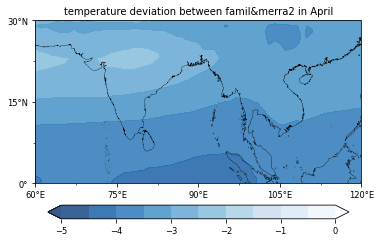

In [19]:
#绘图
import matplotlib as mpl

lonmin, lonmax = 60, 120
latmin, latmax = 0, 30
extent = [lonmin, lonmax, latmin, latmax]
proj = ccrs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(111, projection=proj)
ax.coastlines(resolution='10m', lw=0.3)
set_map_ticks(ax, dx=15, dy=15, nx=1, ny=1, labelsize='small')
ax.set_extent(extent, crs=proj)

im = ax.contourf(
        lon_new, lat_new, t_diff_april,
        levels=np.linspace(-5, 0, 11), cmap='Blues_r',
        extend='both', alpha=0.8
    )
cbar = fig.colorbar(
        im, ax=ax, shrink=0.9, pad=0.1, orientation='horizontal',
    )
cbar.ax.tick_params(labelsize='small')

ax.set_title("temperature deviation between famil&merra2 in April", fontsize='medium')
plt.savefig('/home/sun/paint/famil_con_tem_deviation.pdf', bbox_inches='tight')
plt.show()

In [8]:
t_diff_april

array([[-4.00920573, -4.00223936, -3.99258154, ..., -3.8164557 ,
        -3.82830398, -3.84346609],
       [-4.00497595, -3.99841233, -3.98962258, ..., -3.81289199,
        -3.82577454, -3.82136925],
       [-3.98946921, -3.98511773, -3.97750983, ..., -3.79479087,
        -3.80218068, -3.81116583],
       ...,
       [-2.7638917 , -2.85031818, -2.83393291, ..., -2.9666621 ,
        -2.93140154, -2.90108088],
       [-2.7638917 , -2.85031818, -2.83393291, ..., -2.9666621 ,
        -2.93140154, -2.90108088],
       [-2.7638917 , -2.85031818, -2.83393291, ..., -2.9666621 ,
        -2.93140154, -2.90108088]])